In [20]:
%matplotlib inline
import pylab
import numpy as np
import nengo
import matplotlib.pyplot as plt
#import cPickle as pickle


In [104]:
time_per_val = 0.5
time_per_val_testing = 0.5
train_int = 45
train_time = train_int*time_per_val_testing
childhood = 205
training1 = childhood+train_time
glasses_on = training1+200
training2 = glasses_on+train_time
mod = 23*(np.pi/180) #degrees to rad

In [105]:
def training_fn(t):
    if (t<= childhood) or (training1 <= t < glasses_on):
        return 1
    else:
        return 0

def glasses_fn(t):
    if t >= training1:
        return 1
    else:
        return 0


dist = nengo.dists.Uniform(-np.pi/2, np.pi/2) 
vals_testing = np.linspace(-np.pi/2,np.pi/2, train_int)
training_time1 = childhood
training_time2 = glasses_on-training1
vals_training1 = dist.sample((training_time1/time_per_val)+1)
vals_training2 = dist.sample((training_time2/time_per_val)+1)
    
    
def stim_fn(t, x):
    glasses, train = x
    if glasses < 0.5 and train >= 0.5:
        # First training period, random things appear
        index = int((t - 0)/time_per_val)
        return vals_training1[index% len(vals_training1)]
    if glasses < 0.5 and train < 0.5: 
        # Test the owl by forcing it to incrimentally look at all the things
        # Gives data to form pre-learning tuning curve
        index = int((t - childhood)/time_per_val_testing)
        return vals_testing[index% len(vals_testing)]
    if glasses >= 0.5 and train >= 0.5:
        # Second Training period, random things appear
        index = int((t - training1)/time_per_val)
        return vals_training2[index % len(vals_training2)]
    if glasses >=0.5 and train < 0.5:
        # Last period, test owl by forcing it to incrimentally look at things
        index = int((t-glasses_on)/time_per_val_testing)
        return vals_testing[index % len(vals_testing)]
        
def convert_to_circle(x):
    #takes a value in RADIANS, converts ton x y cartesian coordinates
    # x is gonna be an angle value, we're assuming r=1 for the sake of simplicity
    return np.cos(x), np.sin(x)
    
def is_mod_fn(t, x):
    stim, glasses = x
    if glasses >= 0.5:
        return stim+mod
    else:
        return stim

def error_on(training):
    if training >= 0.5:
        return 1
    else:    
        return 0
        
model = nengo.Network()
with model:
    training = nengo.Node(training_fn)
    glasses = nengo.Node(glasses_fn)
    stim = nengo.Node(stim_fn, size_in = 2, size_out = 1)
    use_mod = nengo.Node(is_mod_fn, size_in = 2, size_out = 1) 
    
    train2stim = nengo.Connection(training, stim[1], synapse = None)
    glasses2stim = nengo.Connection(glasses, stim[0], synapse = None)
    
    # Connecting a bunch of different ensembles
    visual_raw = nengo.Ensemble(n_neurons=300, dimensions=3, intercepts = nengo.dists.Uniform(0.81,0.91))
    auditory = nengo.Ensemble(n_neurons=200, dimensions = 2, intercepts = nengo.dists.Uniform(0.81,0.91))
    stim2use_mod = nengo.Connection(stim, use_mod[0], synapse = None)
    glasses2use_mod = nengo.Connection(glasses, use_mod[1], synapse = None)
    use_mod2vis = nengo.Connection(use_mod, visual_raw[:2], function = convert_to_circle)
    stim2aud = nengo.Connection(stim, auditory, function = convert_to_circle)
    
    # Error stuff
    
    error = nengo.Ensemble(n_neurons = 400, dimensions = 2) #error_fn, size_in = 4, size_out = 2)
    visual_cor = nengo.Ensemble(n_neurons = 200, dimensions = 2, intercepts = nengo.dists.Uniform(0.81,0.91))
    vis2vis = nengo.Connection(visual_raw[:2], visual_cor[:2],synapse = None, learning_rule_type = nengo.PES(learning_rate= 3e-4))
    #vis2vis.learning_rule_type = nengo.PES()
    #nengo.Connection(error, vis2vis.learning_rule)
    vis2vis.solver = nengo.solvers.LstsqL2(weights = False)
    aud2error = nengo.Connection(auditory[:2], error[:2],transform = -1)
    vis2error = nengo.Connection(visual_cor[:2], error[:2])
    
    nengo.Connection(error, vis2vis.learning_rule)
    
    probe = nengo.Probe(visual_cor.neurons)
    probe2 = nengo.Probe(visual_raw.neurons)
    probe_usemod = nengo.Probe(use_mod)
    probe_stim = nengo.Probe(stim)

In [106]:
sim = nengo.Simulator(model)
sim.run(training2)

Simulation finished in 0:05:53.                                                 


In [107]:
print(sim.trange()[-1])
print(training2)

y = sim.data[probe]#[-int():]
mod_data = sim.data[probe_usemod]
stim_data = sim.data[probe_stim]

vis2_data = sim.data[probe2]

450.0
450.0


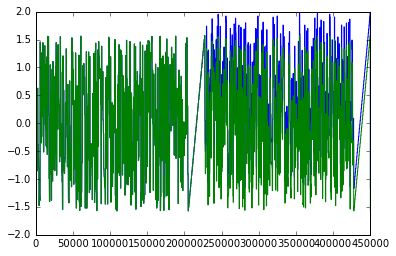

In [108]:
#pylab.plot(mod_data[int(childhood/dt):int(training1/dt)])
#pylab.plot(stim_data[int(childhood/dt):int(training1/dt)])
dt = 0.001
#pylab.plot(mod_data[int(glasses_on/dt):int(training2/dt)], c = 'r')
#pylab.plot(stim_data[int(glasses_on/dt):int(training2/dt)])
pylab.plot(mod_data)
pylab.plot(stim_data)

/home/stacy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/stacy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


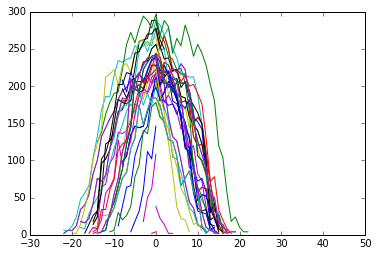

In [109]:
# This code block generates all the graphs for the neurons in the 
# vis_cor ensemble, both before and after learing (supposedly) happens
# They are all plotted on the same graph because I'm lazy
number_of_neurons = 40
mean1_array = []
mean2_array = []
for i in range(number_of_neurons):
    activity = y[:, i]
    dt = 0.001

    test1_activity = activity[int(childhood/dt):int(training1/dt)]
    test2_activity = activity[int(glasses_on/dt):int(training2/dt)]

    mean1_activity = np.mean(test1_activity.reshape(train_int, (time_per_val_testing/dt)),axis=1)
    mean2_activity = np.mean(test2_activity.reshape(train_int, (time_per_val_testing/dt)),axis=1)
    
    indices = np.where(mean1_activity==mean1_activity.max())[0]
    increment = int(max(indices))
    
    indicies_to_adjust1 = np.asarray(np.where(mean1_activity > 0))
    #indicies_to_adjust1 = np.asarray(indicies_to_adjust1)
    ind2 = np.asarray(np.where(mean2_activity>0))
    
    
    # These loops acount for ignoring the tuning curves that are cut off halfway
    if (indicies_to_adjust1[0]).size == 0 or (ind2[0]).size ==0:
        pylab.plot(mean1_activity)
        i += 1
    else:
        l = (indicies_to_adjust1[0][0])
        r = (indicies_to_adjust1[-1][-1])

        indicies_to_adjust1[:] = [(x-increment) for x in indicies_to_adjust1]
        
        x_axis1 = np.transpose(indicies_to_adjust1[-1])
        
        ############ This is the same thing but less indented and for ind2 ###########
        
        l2 = ind2[0][0]
        r2 = ind2[-1][-1]
        ind2[:] = [(x-increment) for x in ind2]
        x_axis2 = np.transpose(ind2[-1])
        
        if mean1_activity[l:r].shape != x_axis1.shape:
            r += 1
            if mean1_activity[l:r].shape != x_axis1.shape:
                i +=1
            else:
                mean1_array.append(mean1_activity[l:r])
                pylab.plot(x_axis1, mean1_activity[l:r])
        
        if mean2_activity[l2:r2].shape != x_axis2.shape:
            r2 +=1
            if mean2_activity[l2:r2].shape != x_axis2.shape:
                i +=1
            else:
                mean2_array.append(mean2_activity[l2:r2])
                #pylab.plot(x_axis2, mean2_activity[l2:r2])
        elif mean1_activity[l:r].shape == x_axis1.shape and mean2_activity[l2:r2].shape == x_axis2.shape:
            mean1_array.append(mean1_activity[l:r])
            pylab.plot(x_axis1, mean1_activity[l:r])
    
            mean2_array.append(mean2_activity[l2:r2])
            #pylab.plot(x_axis2, mean2_activity[l2:r2])
        else:
            i+=1
            

In [110]:
# This takes the average of those curves, which is stupidly annoying
# to write since all the arrays appended were of different sizes
# There was probably a more efficient way of doing this 

mean1_array = np.asarray(mean1_array)


master = []

#print(mean1_array[3])
for j in range(mean1_array.size):
    cur = mean1_array[j] 
    #print(cur)
    cur_length = cur.size
    bound = int(mean1_activity.size/2)
    l_bound = bound * (-1)
    
    z = 0
    while z <= int((mean1_activity.size-cur_length)/2):
        # Add numbers to cur from the left
        add =  np.zeros((mean1_activity.size-cur_length)/2)
        z+=1
    # Force the array to be 45 things long
    cur = np.hstack((add, cur))
    cur = np.hstack((cur, add))
    
    peak = np.max(mean1_array[j])
    peak_pt = np.max(np.where(cur == peak))
    
    i = 0
    if len(cur) != 45: 
        cur = np.hstack((0, cur))
    d = {}
    while i <= len(cur)-1:
        d[cur[i]] = l_bound + i
        i += 1
        
    #print(d[peak])
    #print(len(cur))
    if len(cur) == 45:
        master.append(cur)

#pylab.plot(cur)
#averages = np.mean(mean1_array, axis = 0)
#print(mean1_array)
#print(averages)
#pylab.plot(averages)

/home/stacy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [111]:
mean2_array = np.asarray(mean2_array)
master2 = []
for j in range(mean2_array.size):
    cur = mean2_array[j]
    #print(cur)
    cur_length = cur.size
    bound = int(mean2_activity.size/2)
    l_bound = bound * (-1)
    
    z = 0
    while z <= int((mean2_activity.size-cur_length)/2):
        # Add numbers to cur from the left
        add =  np.zeros((mean2_activity.size-cur_length)/2)
        z+=1
    # Force the array to be 45 things long
    cur = np.hstack((add, cur))
    cur = np.hstack((cur, add))
    
    peak = np.max(mean2_array[j])
    peak_pt = np.max(np.where(cur == peak))
    
    i = 0
    if len(cur) != 45: 
        cur = np.hstack((0, cur))
    d = {}
    while i <= len(cur)-1:
        d[cur[i]] = l_bound + i
        i += 1
        
    #print(d[peak])
    #print(len(cur))
    if len(cur) == 45:
        master2.append(cur)


/home/stacy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


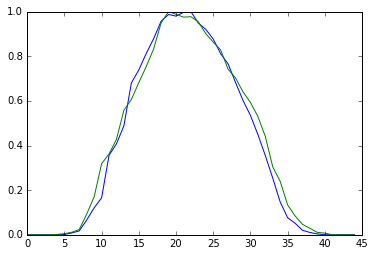

In [112]:
master = np.asarray(master)
master2 = np.asarray(master2)
# w = np.transpose(master)           There was an important reason I did this but I forgot?
m1 = np.mean(master, axis = 0)
m2 = np.mean(master2, axis = 0)

max1 = np.max(m1)
max2 = np.max(m2)
m1 = np.divide(m1, max1)
m2 = np.divide(m2, max2)
#print(master)
#print(master2)
pylab.plot(m1)
pylab.plot(m2)

In [113]:
# We are gonna plot these curves like hell
master = np.asarray(master)
master2 = np.asarray(master2)
# w = np.transpose(master)           There was an important reason I did this but I forgot?
m1 = np.mean(master, axis = 0)
m2 = np.mean(master2, axis = 0)

# Normalize and centre stuff

max1 = np.max(m1)
max2 = np.max(m2)
m1 = np.divide(m1, max1)
m2 = np.divide(m2, max2)

# Now that it's all normalized, we want to centre it again (in hindsight, it would have been wise to 
# write a "centre data" function)

ind_m1 = np.where(m1 == m1.max())[0]

inc_final = int(max(ind_m1))
indicies_to_adjust_m1 = np.asarray(np.where(m1 > 0))

l3 = (indicies_to_adjust_m1[0][0])
r3 = (indicies_to_adjust_m1[-1][-1])
indicies_to_adjust_m1[:] = [(x-inc_final) for x in indicies_to_adjust_m1]
x_axis_m1 = np.transpose(indicies_to_adjust_m1[-1])

# Yo now we centre all the data again, this time for m2 (which contains master2 normalized)

ind_m2 = np.where(m2 == m2.max())[0]

inc_final2 = int(max(ind_m2))
indicies_to_adjust_m2 = np.asarray(np.where(m2 > 0))

l4 = (indicies_to_adjust_m2[0][0])
r4 = (indicies_to_adjust_m2[-1][-1])
indicies_to_adjust_m2[:] = [(x-inc_final2) for x in indicies_to_adjust_m2]
x_axis_m2 = np.transpose(indicies_to_adjust_m2[-1])

print(inc_final, inc_final2)

22 19


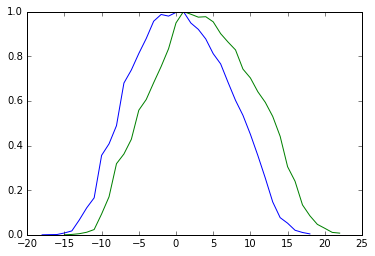

In [114]:
pylab.plot(x_axis_m1, m1[l3-1:r3], c = 'b')
pylab.plot(x_axis_m2, m2[l4-1:r4], c = 'g')